# Bayesian model selection

Author: [Zeel B Patel](https://patel-zeel.github.io/)

http://mlg.eng.cam.ac.uk/teaching/4f13/1920/bayesian%20finite%20regression.pdf (Last slide)
http://mlg.eng.cam.ac.uk/teaching/4f13/1920/marginal%20likelihood.pdf

In [6]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', size=14)
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from time import time

### Pseudo-random data (degree 3 polynomial)

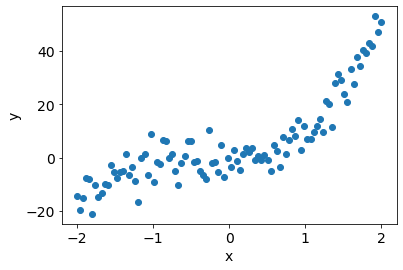

In [7]:
np.random.seed(0)

N = 100
sigma_n = 5 # noise in data
sigma_w = 100 # parameter variance

x = np.linspace(-2,2,N).reshape(-1,1)
f_x = 4*x**3 + 3*x**2 + 2*x + 1
epsilon = np.random.normal(loc=0, scale=sigma_n, size=N).reshape(-1,1)
y = f_x + epsilon

plt.scatter(x, y);
plt.xlabel('x');plt.ylabel('y');

### Marginal likelihood pdf

In [8]:
def LogMarginalLikelihoodPdf(x, y):
    return np.log(scipy.stats.multivariate_normal.pdf(y.squeeze(), np.zeros(N), (x@x.T)*sigma_w**2 + np.eye(N)*sigma_n**2))

### Models

In [9]:
x_M0 = x.copy()
x_M1 = np.hstack([np.ones((N,1)), x])
x_M2 = np.hstack([np.ones((N,1)), x, x**2])
x_M3 = np.hstack([np.ones((N,1)), x, x**2, x**3])
x_M4 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4])
x_M5 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4, x**5])
x_M6 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4, x**5, x**6])
x_M7 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4, x**5, x**6, x**7])

### Model selection

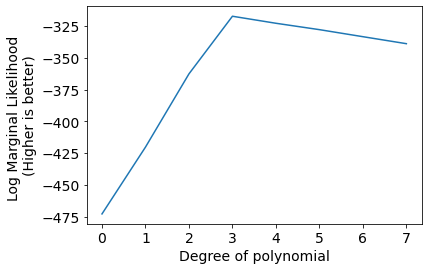

In [10]:
scores = [LogMarginalLikelihoodPdf(x_M, y) for x_M in [x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]]
plt.plot(scores);
plt.xlabel('Degree of polynomial');
plt.ylabel('Log Marginal Likelihood \n(Higher is better)');
plt.xticks(range(len(scores)));

We can infer that Degree 3 polynomial is best suited to model current data.

### Model selection with parameter optimization

In [15]:
def NegLogMarginalLikelihoodPdf(params, x, y): # Negative log marginal likelihood (written in GP fashion)
    sigma_n, sigma_w = params
    K = (x@x.T)*sigma_w**2 + np.eye(N)*sigma_n**2
    K_inv = np.linalg.pinv(K)
    nll = 0.5*y.T@K_inv@y + 0.5*np.log(np.linalg.det(K)) + (len(y)/2)*np.log(2*np.pi)
    return nll[0,0]

degree = 0, sigma_w=11.386419730789676, sig_n_opt=10.409619988275981 time: 0.16215753555297852 seconds
degree = 1, sigma_w=8.895627576152828, sig_n_opt=8.940430356187846 time: 0.08962178230285645 seconds
degree = 2, sigma_w=7.119736606266272, sig_n_opt=6.9430152775634495 time: 0.14646410942077637 seconds
degree = 3, sigma_w=3.219312493175096, sig_n_opt=4.710523287770871 time: 0.14163684844970703 seconds
degree = 4, sigma_w=2.6041389205399996, sig_n_opt=4.739086634960693 time: 0.2660367488861084 seconds
degree = 5, sigma_w=-2.5131468222243427, sig_n_opt=4.745522282327305 time: 0.17346620559692383 seconds
degree = 6, sigma_w=2.163988485988779, sig_n_opt=4.768321344889457 time: 0.5917925834655762 seconds
degree = 7, sigma_w=1.6084504892174767, sig_n_opt=4.758818020810231 time: 0.32204294204711914 seconds


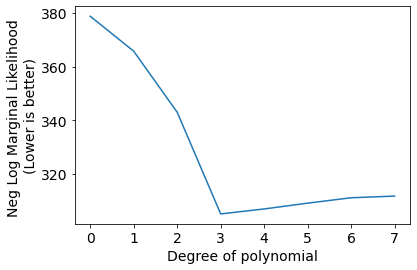

In [16]:
Negscores = []
sig_n_list = []
sig_w_list = []
sig_w = 10
sig_n = 10
for i, x_M in enumerate([x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]):
    init = time()
    result = minimize(fun=NegLogMarginalLikelihoodPdf, x0=(sig_n, sig_w), args=(x_M, y))
    sig_n_opt, sig_w_opt = result.x
    sig_n_list.append(sig_n_opt)
    sig_w_list.append(sig_w_opt)
    print(f'degree = {i}, sigma_w={sig_w_opt}, sig_n_opt={sig_n_opt}', 'time:',time()-init,'seconds')
    Negscores.append(NegLogMarginalLikelihoodPdf((sig_n_opt, sig_w_opt), x_M, y))
plt.plot(Negscores);
plt.xlabel('Degree of polynomial');
plt.ylabel('Neg Log Marginal Likelihood \n(Lower is better)');
plt.xticks(range(len(Negscores)));

We can see the best set of hyper-parameters selected by gradient descent on negative log likelihood for indivisual models (degree of polynomial).

## Drawbacks

1. This method does not scale well with big data (while doing parameter optimization), because of matrix inversion.
    * Potential solution: optimize parameters with chepaer methods, then use Marginal likelihood for model selection

## Using empirical bayes (Bishop)

http://krasserm.github.io/2019/02/23/bayesian-linear-regression/

In [21]:
alpha = 1/sigma_w**2
beta = 1/sigma_n**2

### Marginal likelihood pdf

In [22]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape

    m_N, _, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)
    
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)
    
    score = M * np.log(alpha) + \
            N * np.log(beta) - \
            E_D - \
            E_W - \
            np.log(np.linalg.det(S_N_inv)) - \
            N * np.log(2 * np.pi)

    return 0.5 * score

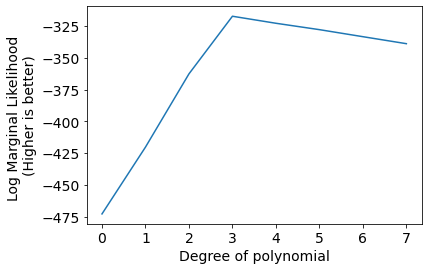

In [23]:
Bscores = [log_marginal_likelihood(x_M, y, alpha, beta) for x_M in [x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]]
plt.plot(Bscores);
plt.xlabel('Degree of polynomial');
plt.ylabel('Log Marginal Likelihood \n(Higher is better)');
plt.xticks(range(len(Bscores)));

Results are exactly the same as the previous method.

### Paramater tuning

In [24]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    
    N, M = Phi.shape

    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N ** 2)

        beta_inv = 1 / (N - gamma) * np.sum((t - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

In [25]:
for i, x_M in enumerate([x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]):
    init = time()
    alpha, beta, m_N, S_N = fit(x_M, y, rtol=1e-5, verbose=True)
    print('Degree',i,'sigma_w',1/np.sqrt(alpha),'sigma_n', 1/np.sqrt(beta))
    print('Degree',i,'sigma_w',sig_w_list[i],'sigma_n', sig_n_list[i], '(Earlier method)')
    print('time:',time()-init,'seconds')

Convergence after 3 iterations.
Degree 0 sigma_w 11.386046324847063 sigma_n 10.409625056741909
Degree 0 sigma_w 11.386419730789676 sigma_n 10.409619988275981 (Earlier method)
time: 0.0020685195922851562 seconds
Convergence after 3 iterations.
Degree 1 sigma_w 8.89562357924776 sigma_n 8.940424942304906
Degree 1 sigma_w 8.895627576152828 sigma_n 8.940430356187846 (Earlier method)
time: 0.006841897964477539 seconds
Convergence after 3 iterations.
Degree 2 sigma_w 7.119729723394079 sigma_n 6.943013815169844
Degree 2 sigma_w 7.119736606266272 sigma_n 6.9430152775634495 (Earlier method)
time: 0.0012140274047851562 seconds
Convergence after 4 iterations.
Degree 3 sigma_w 3.219311433389237 sigma_n 4.710523173354075
Degree 3 sigma_w 3.219312493175096 sigma_n 4.710523287770871 (Earlier method)
time: 0.0022554397583007812 seconds
Convergence after 6 iterations.
Degree 4 sigma_w 2.6041361190065677 sigma_n 4.739086719922639
Degree 4 sigma_w 2.6041389205399996 sigma_n 4.739086634960693 (Earlier meth

This method is extremely fast than the previous method. We get close answers while using any of the two methods.